In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
import torch
import torch.nn as nn
from scipy.spatial import Voronoi, voronoi_plot_2d

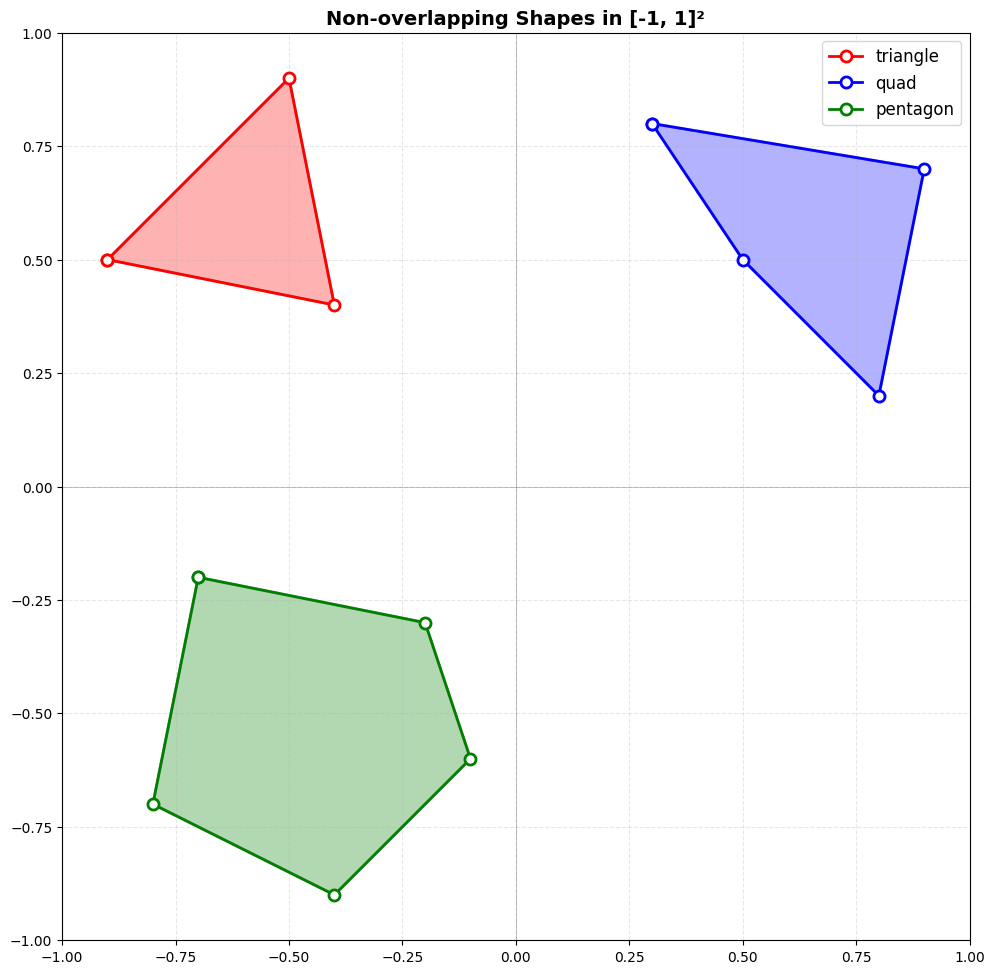

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon

# ==================== Define Shapes ====================

# Triangle (3 vertices, upper left)
triangle = np.array([
    [-0.9, 0.5],
    [-0.5, 0.9],
    [-0.4, 0.4]
])

# Quad (4 vertices, right side, non-convex)
quad = np.array([
    [0.3, 0.8],
    [0.9, 0.7],
    [0.8, 0.2],
    [0.5, 0.5]  # This vertex creates concavity
])

# Pentagon (5 vertices, bottom, non-convex)
pentagon = np.array([
    [-0.7, -0.2],
    [-0.2, -0.3],
    [-0.1, -0.6],  # This vertex creates concavity
    [-0.4, -0.9],
    [-0.8, -0.7]
])

shapes = {
    'triangle': triangle,
    'quad': quad,
    'pentagon': pentagon
}

# ==================== Visualization ====================

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

colors = {'triangle': 'red', 'quad': 'blue', 'pentagon': 'green'}

for shape_name, vertices in shapes.items():
    polygon = MplPolygon(vertices, facecolor=colors[shape_name], 
                        edgecolor='black', alpha=0.3, linewidth=2)
    ax.add_patch(polygon)
    
    closed_verts = np.vstack([vertices, vertices[0]])
    ax.plot(closed_verts[:, 0], closed_verts[:, 1], 'o-', 
            color=colors[shape_name], linewidth=2, markersize=8,
            label=shape_name, markerfacecolor='white', 
            markeredgewidth=2, markeredgecolor=colors[shape_name])

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=0, color='k', linewidth=0.5, alpha=0.3)
ax.axvline(x=0, color='k', linewidth=0.5, alpha=0.3)
ax.legend(loc='upper right', fontsize=12)
ax.set_title('Non-overlapping Shapes in [-1, 1]²', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Total edges: 12
Computing Voronoi diagram... (may take a few seconds)
Grid resolution: torch.Size([800, 800])
Number of Voronoi regions: 12


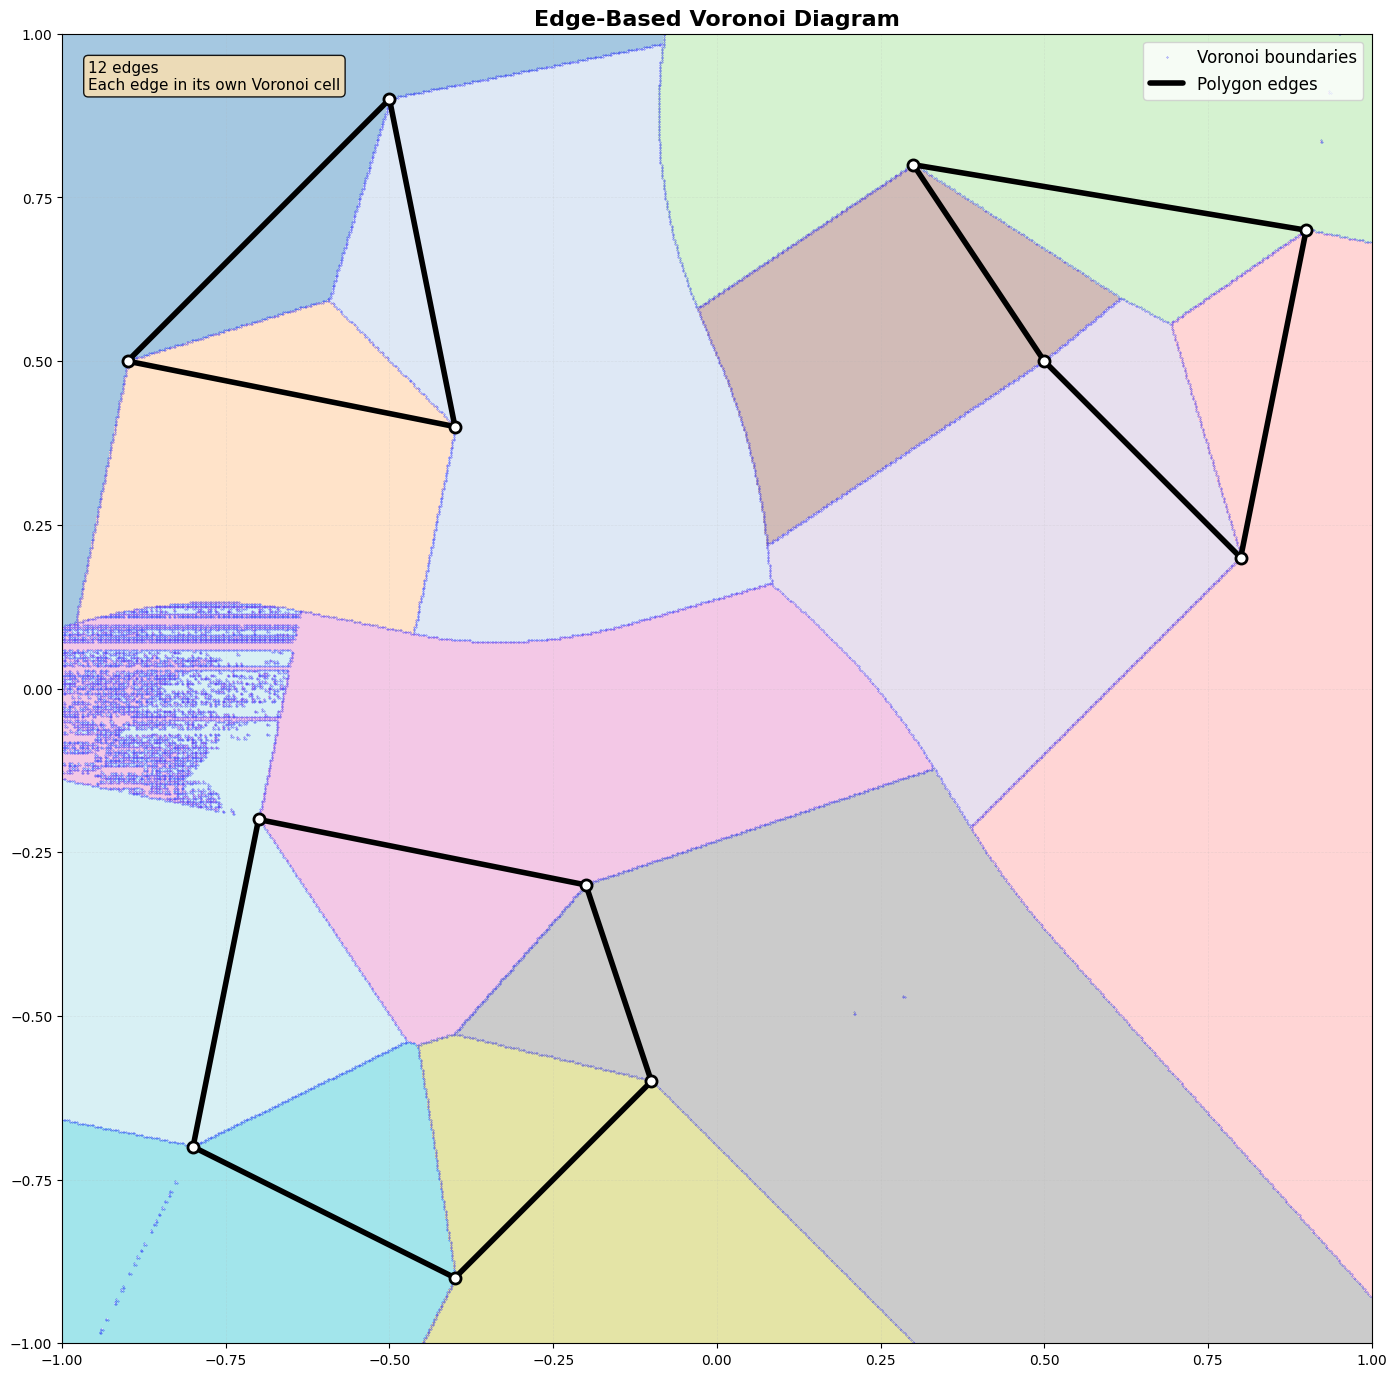

✓ Done! Each polygon edge is in its own colored Voronoi region.


In [3]:
from analytic_inr import voronoi
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
import numpy as np

# Convert your shapes to torch tensors
polygon_list = [
    torch.tensor(triangle, dtype=torch.float32),
    torch.tensor(quad, dtype=torch.float32),
    torch.tensor(pentagon, dtype=torch.float32)
]

# Get edges from polygons
edges = voronoi.polygons_to_edges(polygon_list)
print(f"Total edges: {len(edges)}")

# Compute the edge-based Voronoi diagram with HIGH resolution
print("Computing Voronoi diagram... (may take a few seconds)")
grid_x, grid_y, voronoi_labels, distances = voronoi.compute_edge_voronoi_grid(
    edges, 
    grid_resolution=800,  # High resolution for clean boundaries
    bounds=(-1, 1),
    device='cpu'  # Use 'cuda' if you have GPU
)

print(f"Grid resolution: {grid_x.shape}")
print(f"Number of Voronoi regions: {len(edges)}")

# Visualize
fig, ax = plt.subplots(figsize=(14, 14))

# Show Voronoi regions as colored contours (clean discrete regions)
im = ax.imshow(voronoi_labels.cpu().numpy(), 
               extent=[-1, 1, -1, 1], 
               origin='lower',
               cmap='tab20', 
               alpha=0.4,
               interpolation='nearest')

# Draw Voronoi boundaries cleanly
boundary_x, boundary_y = voronoi.get_voronoi_boundary_points(voronoi_labels, grid_x, grid_y)
ax.plot(boundary_x, boundary_y, 'b.', markersize=0.5, alpha=0.8, label='Voronoi boundaries')

# Plot original polygon edges (THICK black lines on top)
for i, (start, end) in enumerate(edges):
    start_np = start.cpu().numpy()
    end_np = end.cpu().numpy()
    ax.plot([start_np[0], end_np[0]], [start_np[1], end_np[1]], 
           'k-', linewidth=4, alpha=1.0, zorder=100, 
           solid_capstyle='round', label='Polygon edges' if i == 0 else '')

# Plot vertices
for polygon in polygon_list:
    vertices_np = polygon.cpu().numpy()
    ax.plot(vertices_np[:, 0], vertices_np[:, 1], 'ko', 
           markersize=8, zorder=101, markerfacecolor='white',
           markeredgewidth=2)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
ax.legend(loc='upper right', fontsize=12)
ax.set_title('Edge-Based Voronoi Diagram', fontsize=16, fontweight='bold')
ax.text(0.02, 0.98, f'{len(edges)} edges\nEach edge in its own Voronoi cell', 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

plt.tight_layout()
plt.show()

print("✓ Done! Each polygon edge is in its own colored Voronoi region.")